# Sidekick - Exploratory Data Analysis
We explore the data in the Sidekick dataset.

In [1]:
%matplotlib inline
from __future__ import print_function
import os
import sys
sys.path.insert(0, os.path.abspath('../utils/')) # Add sibling to Python path
sys.path.insert(0, os.path.abspath('../src/')) # Add sibling to Python path
sys.stdout.flush() # Print output on the fly in Notebook
import matplotlib
matplotlib.rcParams['figure.figsize'] = (12,8)
matplotlib.rcParams['font.size'] = 16
matplotlib.rcParams['legend.fontsize'] = 16
from IPython.display import display
import numpy as np
import GPy
import pickle as cp
import matplotlib.pyplot as plt
from math import floor
from dataset import Sidekick

DATA_DIR = "../data/sidekick"

def extract_jumps_and_times(project):
    jumps = np.diff(project.money)
    # -1 as first index to count the first jump (between 0 and the first pledge)
    times = np.diff([-1] + [i for i, j in enumerate(jumps) if j != 0])
    jumps = filter(lambda j: j != 0, jumps)
    return jumps, times

def show_histogram(y, x_label, y_label, x_scale='linear', y_scale='linear', bins=100, width=0.7):
    hist, bins = np.histogram(y, bins=bins)
    w = width * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.bar(center, hist, align='center', width=w)
    # Make counts of 1 visible in log scale
    ax.set_ylim(0.9, ax.get_ylim()[1] + 0.1 * ax.get_ylim()[1])
    ax.set_yscale(y_scale)
    ax.set_xscale(x_scale)
    ax.set_ylabel(y_label)
    ax.set_xlabel(x_label)
    plt.show()
    return hist, bins
    
def generate_jumps_times(iterable_collection_of_project):
    jumps = []
    times = []
    for project in iterable_collection_of_project:
        j, t = extract_jumps_and_times(project)
        jumps.extend(j)
        times.extend(t)
    return jumps, times

### Load data

In [3]:
sk = Sidekick()
sk.load()
train, test = sk.split(threshold=0.7)
successful = [p for p in train if p.successful]
failed = [p for p in train if not p.successful]
#successful = sk.successful()
#failed = sk.failed()

Loading data set...
Data loaded.


## Project
Display an arbitrary or randomly selected project.

Goal: $2000
Pledged: $2265


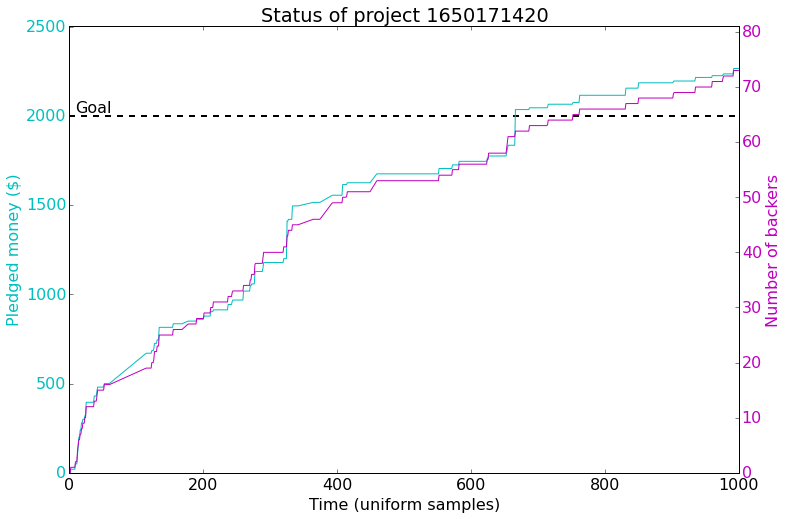

Project 1650171420 is successful


In [5]:
project = sk.choose_n_projects(n=1)[0]
#project = sk['14035777']
project.plot()
print(project)

## Histograms
First we plot the histograms for the distribution of increase in money and time between jumps for all the projects, only the succesful ones and only the failed ones.

### Global
We consider first all the projects.

In [26]:
jumps, times = generate_jumps_times(sk)

#### Global - Histogram of jumps

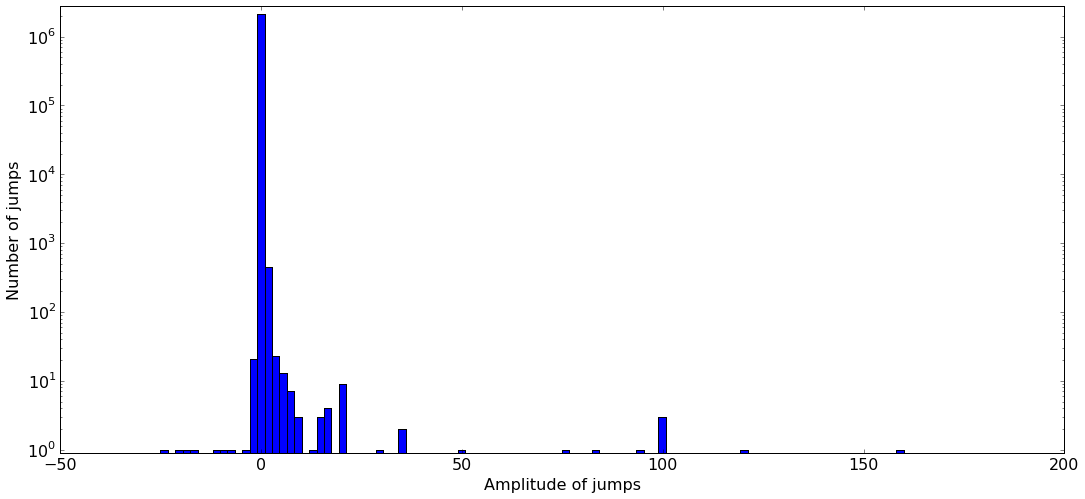

In [48]:
hist, bins = show_histogram(jumps, 
               x_label='Amplitude of jumps', 
               y_label='Number of jumps', 
               x_scale='linear', 
               y_scale='log', 
               bins=100,
               width=1)

#### Global - Histogram of times

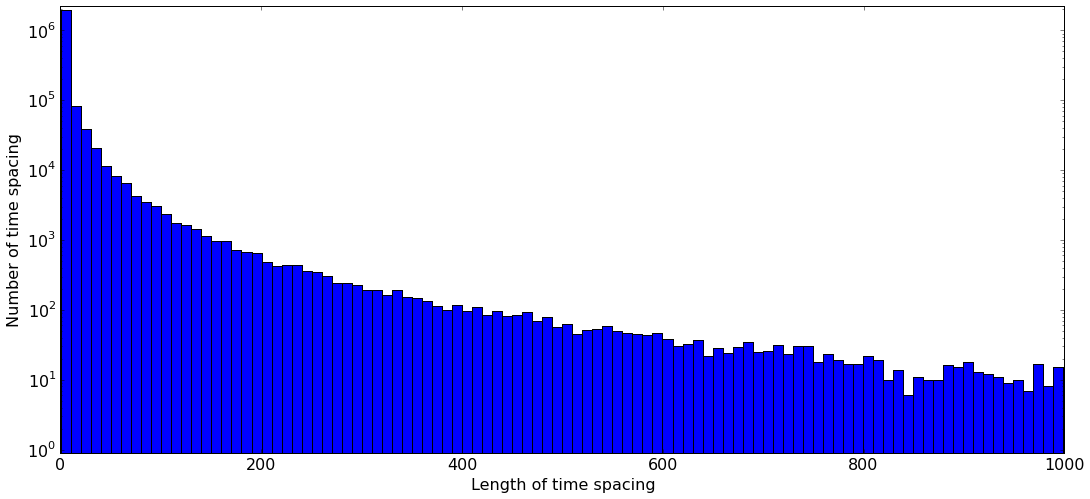

In [47]:
hist, bins = show_histogram(times, 
               x_label='Length of time spacing', 
               y_label='Number of time spacing', 
               x_scale='linear', 
               y_scale='log', 
               bins=100,
               width=1)

### Successful projects
We consider now only the successful projects.

In [29]:
jumps_successful, times_successful = generate_jumps_times(successful)

#### Successful - Histogram of jumps

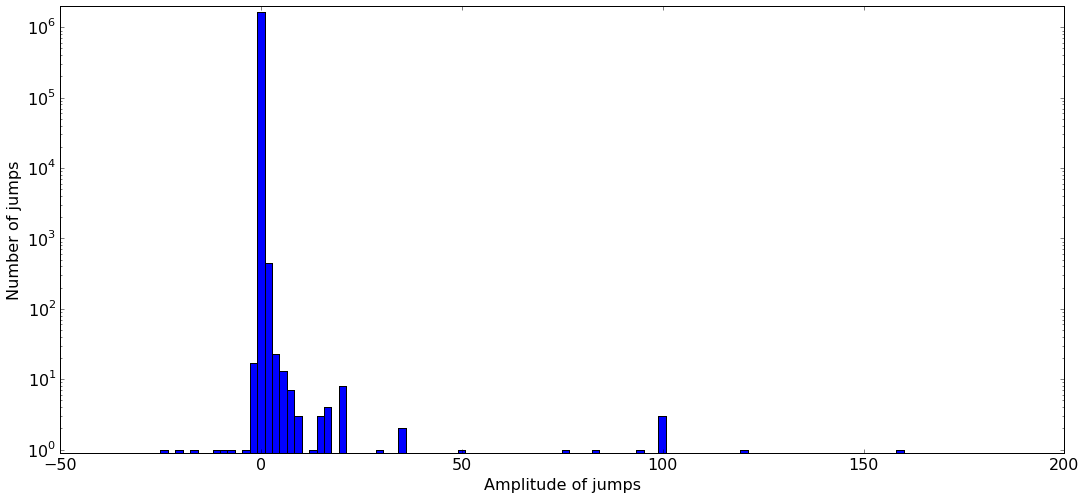

In [46]:
hist, bins = show_histogram(jumps_successful, 
               x_label='Amplitude of jumps', 
               y_label='Number of jumps', 
               x_scale='linear', 
               y_scale='log', 
               bins=100,
               width=1)

#### Successful - Histogram of times

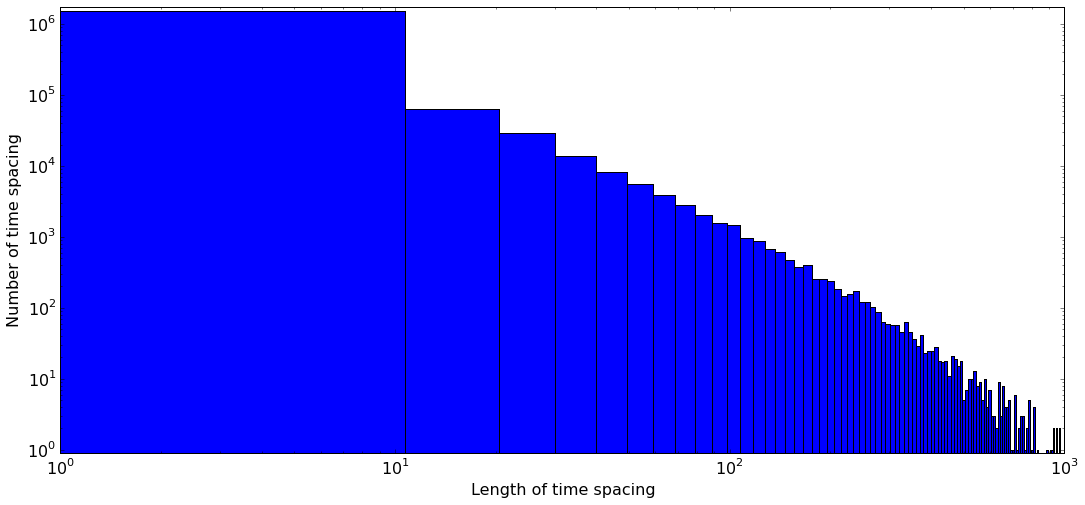

In [33]:
hist, bins = show_histogram(times_successful, 
               x_label='Length of time spacing', 
               y_label='Number of time spacing', 
               x_scale='log', 
               y_scale='log', 
               bins=100,
               width=1)

### Failed projects
We consider now only the failed projects.

In [10]:
jumps_failed, times_failed = generate_jumps_times(failed)

#### Failed - Histogram of jumps

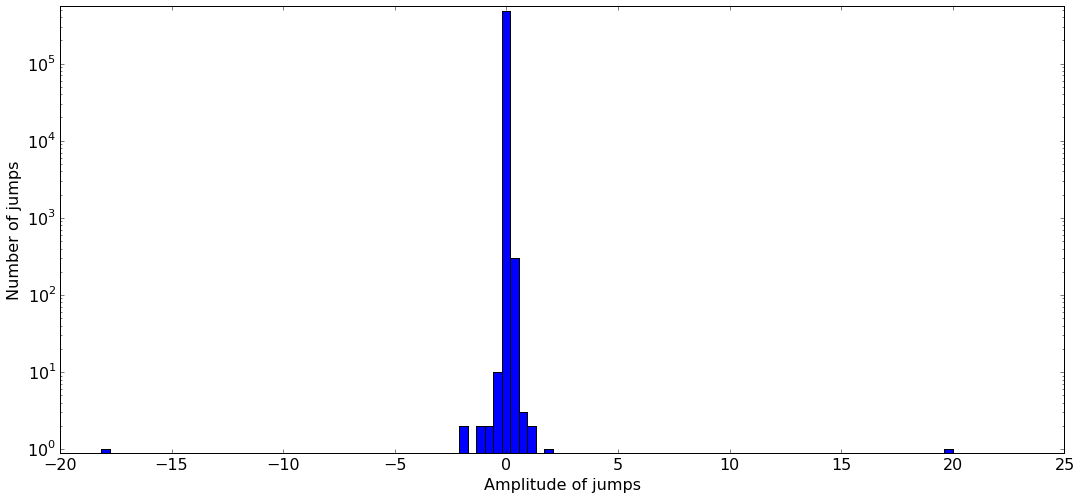

In [45]:
hist, bins = show_histogram(jumps_failed, 
               x_label='Amplitude of jumps', 
               y_label='Number of jumps', 
               x_scale='linear', 
               y_scale='log', 
               bins=100,
               width=1)

#### Failed - Histogram of times

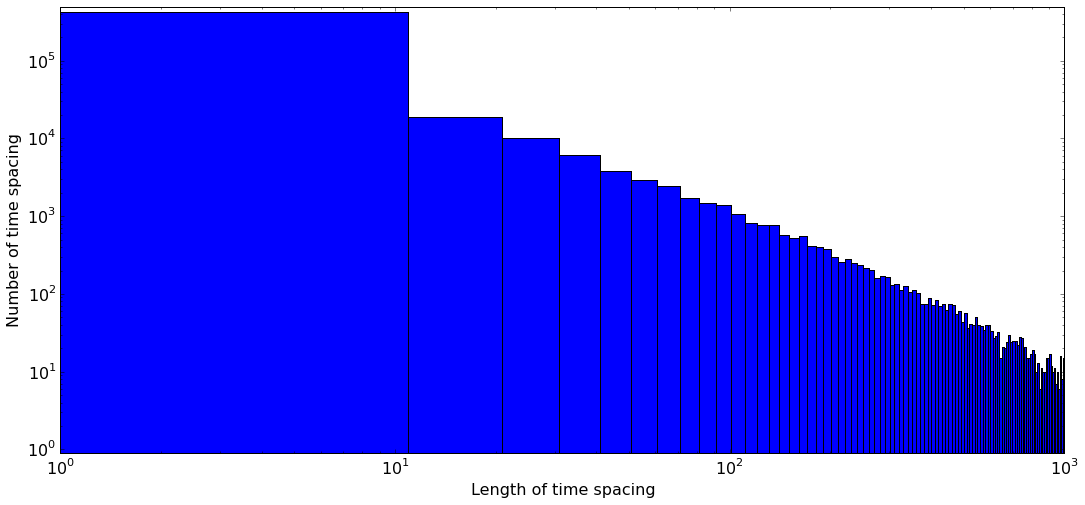

In [38]:
hist, bins = show_histogram(times_failed, 
               x_label='Length of time spacing', 
               y_label='Number of time spacing', 
               x_scale='log', 
               y_scale='log',
               bins=100,
               width=1)

## Outliers
We take a look at the outliers in the total amount of pledeged money for the successful and the failed projects separately.

### Outliers - Successful

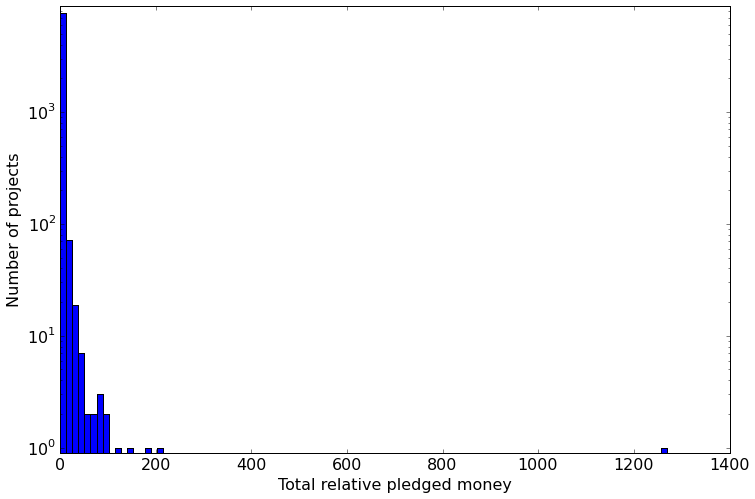

[7627   72   19    7    2    2    3    2    0    1    0    1    0    0    1
    0    1    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    1]
[  3.91106109e-01   1.30871950e+01   2.57832840e+01   3.84793729e+01
   5.11754619e+01   6.38715508e+01   7.65676397e+01   8.92637287e+01
   1.01959818e+02   1.14655907e+02   1.27351995e+02   1.40048084e+02
   1.52744173e+02   1.65440262e+02   1.78136351e+02   1.90832440e+02
   2.03528529e+02   2.16224618e+02   2.28920707e+02   2.41616796e+02
   2.54312885e+02   2.67008974e+02   2.79705063e+02   2.92401152e+02
   3.05097241e+02   3.17793330e+02   3.30489419e+02   3.43185507e+02
   3.5588

In [9]:
goal_successful = [project.money[-1] for project in sk if project.successful]
hist, bins = show_histogram(goal_successful,
               x_label='Total relative pledged money',
               y_label='Number of projects',
               x_scale='linear',
               y_scale='log',
               bins=100,
               width=1)
print(hist)
print(bins)
print(len(sorted([g for g in goal_successful if g > 38.5])))

###  Outliers - Failed

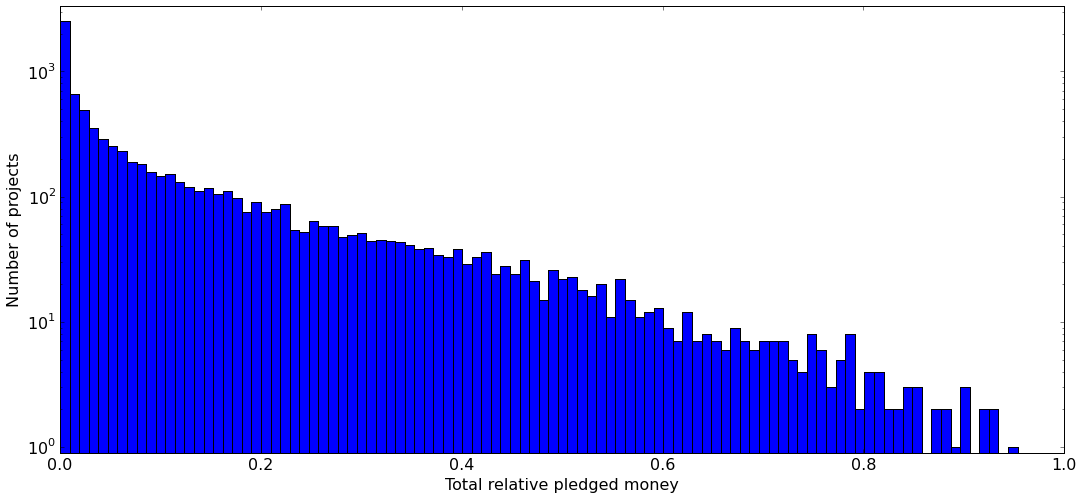

In [44]:
goal_failed = [project.money[-1] for project in sk if not project.successful]
hist, bins = show_histogram(goal_failed,
                            x_label='Total relative pledged money',
                            y_label='Number of projects',
                            x_scale='linear',
                            y_scale='log',
                            bins=100,
                            width=1)

## Prototypes
We display here the "prototypical" successful and failed projects by their mean and averaged standard deviation. We notice that there a clear difference between the two, even with very few observations. Therefore, there is definitely a way to discriminate between the two, but the current approach is not correct.

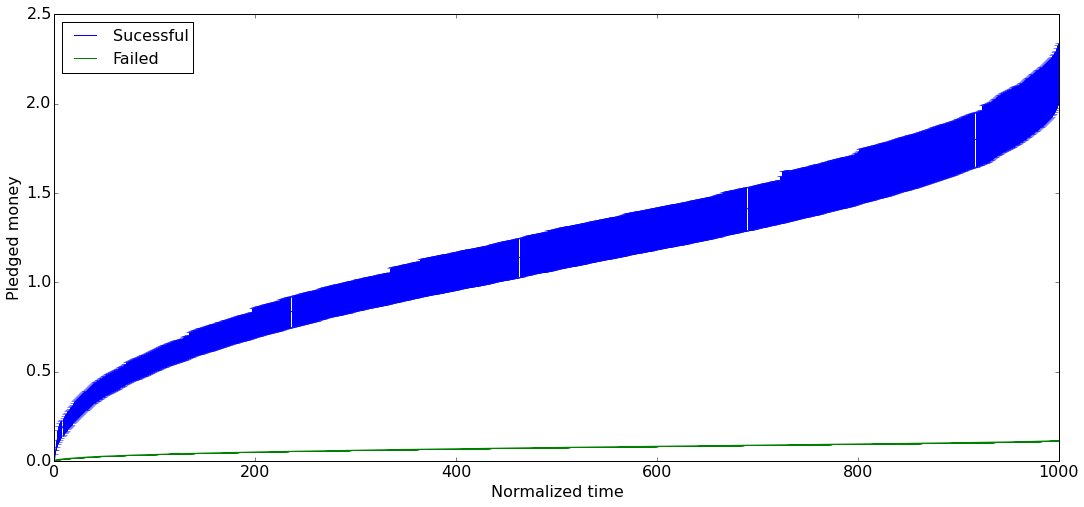

In [54]:
mean_s = np.mean(successful, axis=0)
std_s = np.std(successful, axis=0)
mean_f = np.mean(failed, axis=0)
std_f = np.std(failed, axis=0)
plt.errorbar(range(1000), mean_s, std_s / np.sqrt(len(successful)))
plt.errorbar(range(1000), mean_f, std_f / np.sqrt(len(failed)))
plt.legend(['Sucessful', 'Failed'], loc=2)
plt.xlabel('Normalized time')
plt.ylabel('Pledged money')
plt.show()

## Output as input
We visualize the final state of a project $y_T$ versus its state at time $t$ $y_t$. That is, we consider $y_T$ as the target to be predicted and $y_t$ as a feature. The idea is, for a given project $p$, to use $\mathbf{y}_{1:t}^{(p)}$ as features to predict $y_T^{(p)}$

### Output as input - Global

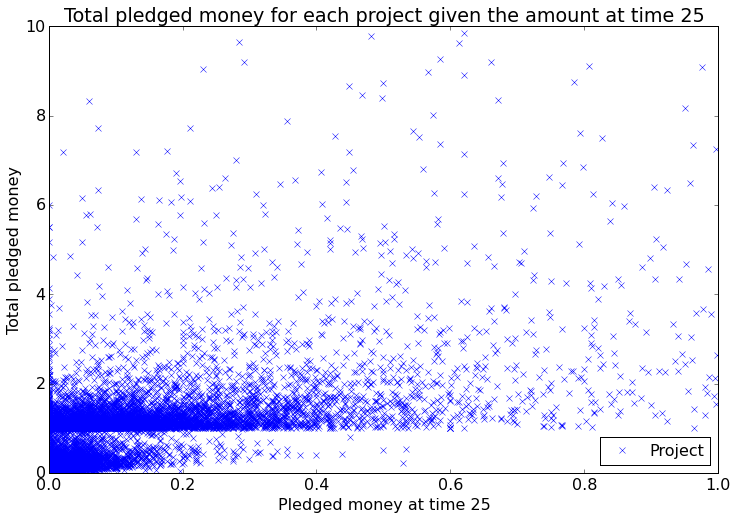

In [21]:
T = 999
t = 25
yt = [p.money[t] for p in sk if p.money[T] < 10 and p.money[t] < 1]
yT = [p.money[T] for p in sk if p.money[T] < 10 and p.money[t] < 1]
plt.plot(yt, yT, 'x')
plt.xlabel('Pledged money at time %s' % t)
plt.ylabel('Total pledged money')
plt.legend(['Project'], loc=4, numpoints=1)
plt.title('Total pledged money for each project given the amount at time %s' % t)
plt.savefig('input_output_global.pdf')
plt.show()

###  Output as input - Successful

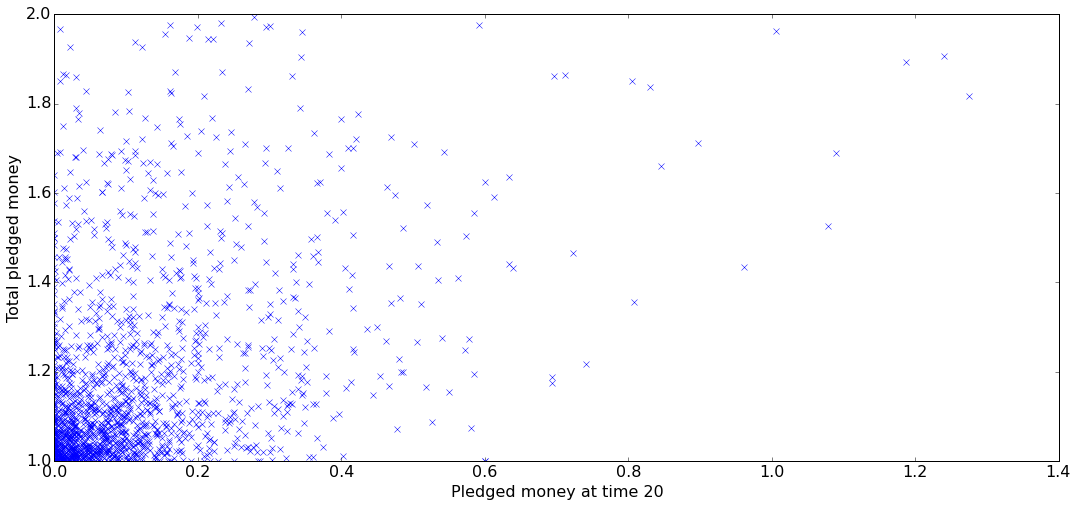

In [50]:
T = 999
t = 20
N = 2000
successful_light = successful[:N]
successful_light = [s for s in successful_light if s.money[T] < 2]
yt = [p.money[t] for p in successful_light]
yT = [p.money[T] for p in successful_light]
plt.plot(yt, yT, 'x')
plt.xlabel('Pledged money at time %s' % t)
plt.ylabel('Total pledged money')
plt.show()

###  Output as input - Failed

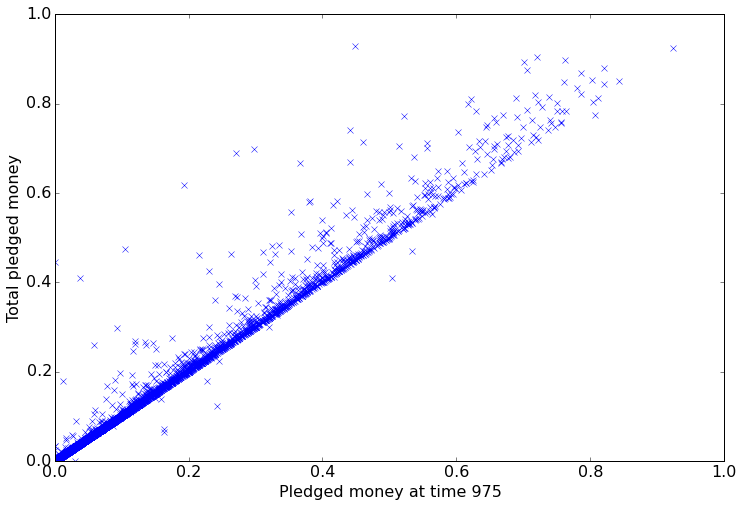

In [4]:
T = 999
t = 975
yt = [p.money[t] for p in failed if p.money[T] < 100 and p.money[t] < 1]
yT = [p.money[T] for p in failed if p.money[T] < 100 and p.money[t] < 1]
plt.plot(yt, yT, 'x')
plt.xlabel('Pledged money at time %s' % t)
plt.ylabel('Total pledged money')
plt.show()